Home work - feature engineering 
--- 

На лекциях 6 и 7 мы рассмотрели много приемов, как можно строить прогнозы, используя не только классические модели временных рядов. 

В этом домашнем задании я предлагаю вам проявить свободу творчества и попробовать различные методы. 
Здесь будут гайдлайны - советы, но им не обязательно следовать строго.

Вы можете приложить два ноутбука - один "черновик", где вы пробуете различные методы и делаете свои выводы. Второй - "чистовик" с оптимальной моделью, графиком и результатами.

Временной ряд №1
----

In [2]:
import pandas as pd

df1 = pd.read_csv('../datatest/monthly-car-sales.csv')

Задание:
---
* Задача стоит построить прогноз на следующий год на все 12 месяцев.
* Построить признаки, основанные на времени (месяц, код), а также используя target encoding
* Построить признаки, основанные на lagged values
* Посмотреть, какие признаки работают лучше, возможно стоит скомбинировать? 
* При тестировании лучше всего пользоваться кросс-валидацией. Можно библиотекой.

In [1]:
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import *
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from xgboost import XGBRegressor
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

In [3]:
df1.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [4]:
df1['Month']=pd.to_datetime(df1['Month'])

<AxesSubplot:xlabel='Month'>

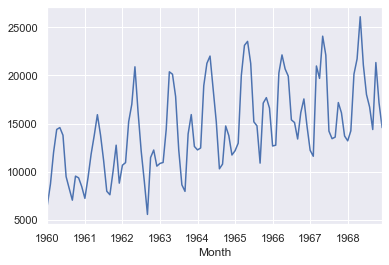

In [5]:
df1.set_index('Month')['Sales'].plot()

In [6]:
target = 'Sales'

In [11]:
for i in range(1,12):
    df1[f'i-{i}'] = df1[target].shift(i)

In [12]:
df1[['i-'+str(i) for i in range(1,12)]+[target]].corr()[target]

i-1      0.728068
i-2      0.367645
i-3      0.076004
i-4      0.030571
i-5      0.170231
i-6      0.213944
i-7      0.146070
i-8     -0.011016
i-9      0.020582
i-10     0.308732
i-11     0.709073
Sales    1.000000
Name: Sales, dtype: float64

In [14]:
df1.fillna(df1.mean(),inplace=True)

In [19]:
features = ['i-'+str(i) for i in range(1,12)]

error = list()
train, test = df1[0:-12],df1[-12:]
predictions = list()

for i in range(len(test)):
    step = test[i:i+1]
    mod = LinearRegression()
    mod.fit(train[features],train[target])
    preds = mod.predict(step[features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step[target],preds))

    train = pd.concat([train,step])

In [20]:
np.mean(error)

1871.716018123551

In [21]:
r2_score(test[target],predictions)

0.6591671481327407

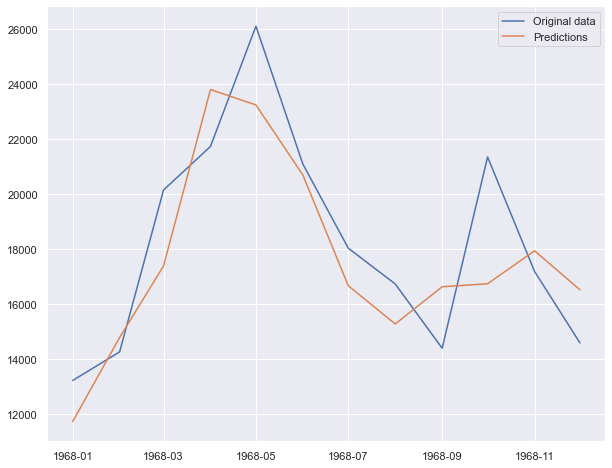

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Month'], test[target], label = 'Original data')
plt.plot(test['Month'], predictions, label = 'Predictions')
ax.legend()
plt.show()

In [23]:
df1['weekday'] = df1['Month'].dt.weekday

In [24]:
df1['month_num'] = df1['Month'].dt.month

In [26]:
df1['year'] = df1['Month'].dt.year

In [27]:
features = ['weekday', 'year', 'month_num']

In [28]:
enc = ce.TargetEncoder(cols=features)

In [29]:
error = list()

train, test = df1[0:-12],df1[-12:]
predictions = list()

for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train[target])
    mod = LinearRegression()
    mod.fit(train_encoded[features],train_encoded[target])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step_encoded[target],preds))

    train = pd.concat([train,step])

In [30]:
np.mean(error)

1861.7578277886987

In [31]:
r2_score(test[target],predictions)

0.6427879355777087

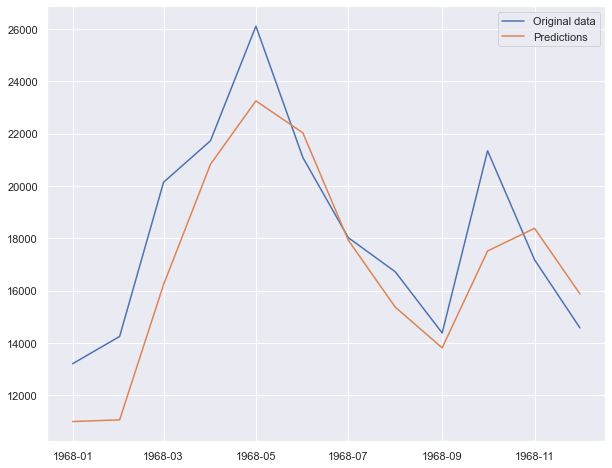

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Month'], test[target], label = 'Original data')
plt.plot(test['Month'], predictions, label = 'Predictions')
ax.legend()
plt.show()

In [34]:
lagged_features = ['i-'+str(i) for i in range(1,12)]
cat_features = ['weekday', 'year', 'month_num']

In [35]:
error = list()


train, test = df1[0:-12],df1[-12:]
predictions = list()
enc = ce.TargetEncoder(cols=cat_features)

for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train[target])
    mod = LinearRegression()
    mod.fit(train_encoded[cat_features+lagged_features],train_encoded[target])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[cat_features+lagged_features])
    predictions.append(preds[0])
    error.append(mean_absolute_error(step_encoded[target],preds))

    train = pd.concat([train,step])

In [36]:
np.mean(error)

1828.2762813796478

In [37]:
r2_score(test[target],predictions)

0.6452094400550916

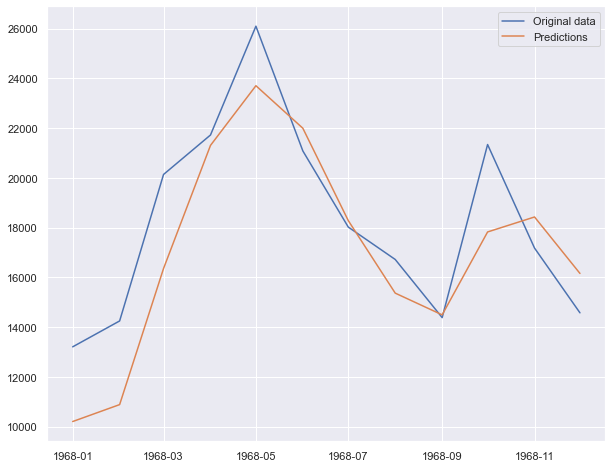

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Month'], test[target], label = 'Original data')
plt.plot(test['Month'], predictions, label = 'Predictions')
ax.legend()
plt.show()

Временной ряд №2
---
Колонки
* Period - дата 
* Revenue - Доход (таргет)
* Sales_quantity - количество проданных товаров. Можно использовать как признак, но только не в текущий момент времени, так как мы не знаем, сколько мы товаров продадим на момент прогноза
* Average_cost - средняя цена товара (Revenue / Sales_quantity) 

In [69]:
df2 = pd.read_csv('../datatest/month_value.csv')

In [70]:
df2.head()

,Period,Revenue,Sales_quantity,Average_cost
0,01.01.2015,1.601007e+07,12729.0,1257.763541
1,01.02.2015,1.580759e+07,11636.0,1358.507000
2,01.03.2015,2.204715e+07,15922.0,1384.697024
3,01.04.2015,1.881458e+07,15227.0,1235.606705
4,01.05.2015,1.402148e+07,8620.0,1626.621765


In [71]:
# correlations
df2.corr()

,Revenue,Sales_quantity,Average_cost
Revenue,1.000000,0.887570,0.358278
Sales_quantity,0.887570,1.000000,-0.093599
Average_cost,0.358278,-0.093599,1.000000


Задание 
---
Используя предыдущие приемы, а так же добавив еще признаки из датасета, так же построить прогноз на 3 месяца и на год вперед

In [72]:
df2['Period']=pd.to_datetime(df2['Period'])

<AxesSubplot:xlabel='Period'>

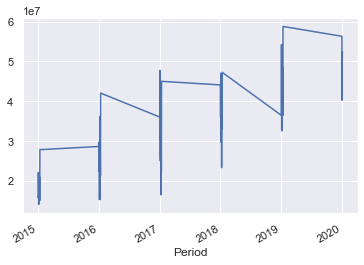

In [73]:
df2.set_index('Period')['Revenue'].plot()

In [49]:
target = 'Revenue'

In [74]:
for i in range(1,12):
    df2[f'q-{i}'] = df2['Sales_quantity'].shift(i)

In [75]:
for i in range(1,12):
    df2[f'p-{i}'] = df2['Average_cost'].shift(i)

In [76]:
df2.head()

,Period,Revenue,Sales_quantity,Average_cost,q-1,q-2,q-3,q-4,q-5,q-6,...,p-2,p-3,p-4,p-5,p-6,p-7,p-8,p-9,p-10,p-11
0,2015-01-01,1.601007e+07,12729.0,1257.763541,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,1.580759e+07,11636.0,1358.507000,12729.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,2.204715e+07,15922.0,1384.697024,11636.0,12729.0,NaN,NaN,NaN,NaN,...,1257.763541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,1.881458e+07,15227.0,1235.606705,15922.0,11636.0,12729.0,NaN,NaN,NaN,...,1358.507000,1257.763541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,1.402148e+07,8620.0,1626.621765,15227.0,15922.0,11636.0,12729.0,NaN,NaN,...,1384.697024,1358.507000,1257.763541,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df2.fillna(df2.mean(),inplace=True)

In [78]:
df2['month_num'] = df2['Period'].dt.month
df2['year'] = df2['Period'].dt.year

In [91]:
lagged_features_q = ['q-'+str(i) for i in range(1,12)]
lagged_features_p = ['p-'+str(i) for i in range(1,12)]

In [92]:
cat_features = ['year', 'month_num']

In [93]:
error_q = list()


train, test = df2[0:-12],df2[-12:]
predictions_q = list()
enc = ce.TargetEncoder(cols=cat_features)

for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train['Sales_quantity'])
    mod = LinearRegression()
    mod.fit(train_encoded[cat_features+lagged_features_q],train_encoded['Sales_quantity'])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[cat_features+lagged_features_q])
    predictions_q.append(preds[0])
    error_q.append(mean_absolute_error(step_encoded[target],preds))

    train = pd.concat([train,step])

In [94]:
error_p = list()


train, test = df2[0:-12],df2[-12:]
predictions_p = list()
enc = ce.TargetEncoder(cols=cat_features)

for i in range(len(test)):
    step = test[i:i+1]
    train_encoded = enc.fit_transform(train, train['Average_cost'])
    mod = LinearRegression()
    mod.fit(train_encoded[cat_features+lagged_features_p],train_encoded['Average_cost'])
    step_encoded=  enc.transform(step)
    preds = mod.predict(step_encoded[cat_features+lagged_features_p])
    predictions_p.append(preds[0])
    error_p.append(mean_absolute_error(step_encoded[target],preds))


    train = pd.concat([train,step])

In [98]:
predictions = np.multiply(predictions_q, predictions_p)

In [102]:
predictions

array([25652445.60340974, 41208167.01945422, 31833920.03188691,
       29040025.89456188, 51286141.46051052, 44555810.06715273,
       36771931.631209  , 53012283.71217062, 33620872.31866804,
       34396780.53077425, 60768928.2848786 , 40680965.42943995])

In [100]:
r2_score(test[target],predictions)

-0.6405995329776832

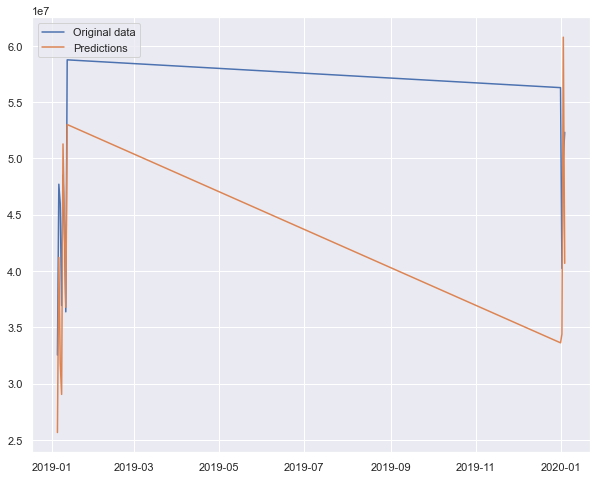

In [101]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(test['Period'], test[target], label = 'Original data')
plt.plot(test['Period'], predictions, label = 'Predictions')
ax.legend()
plt.show()